In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from metrics import mia_efficacy
import data
from models import get_model
from metrics import calculate_accuracy

/ibex/scratch/gasanoe/unlearning/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Collecting metrics

In [2]:
log_dir_dict_finetuned = {
    'SCRUB': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-14:34:39_SCRUB',
    'neggradplus': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-24-14:40:55_neggradplus',
    'euk': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-18:25:20_eu_9_at_shot_epoch_0',
    'our_method': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.025_untrain07-24-15:52:07_constrained_lagrange',
    'original_model': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_sam_True_rho_0.5_lr_0.1_07-03-09:33:15',
    'retrain': '/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_07-23-09:24:12'
}

## Downloading the dataset

In [3]:
dataset_handler = data.CIFAR100Handler(batch_size=128,
                                       validation_split=0.1,
                                       random_seed=42,
                                       data_dir='/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/data/cifar100')
data_confuser = data.uniform_confuser(confuse_level=.0, random_seed=42)
splitter = data.mix_both_sets(
    amend_split=1.,
    retain_split=0.1,
    random_seed=42
    )
confused_dataset_handler = data.AmendedDatasetHandler(
    dataset_handler,
    data_confuser,
    splitter,
    class_wise_corr=True
    )
train_loader, val_loader, test_loader, forget_loader, retain_loader, unseen_loader = confused_dataset_handler.get_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


## Collecting metrics

In [4]:
all_values_retain_top5 = dict()
for (key, log_dir) in log_dir_dict_finetuned.items():
    if key in ['original_model', 'euk', 'retrain']:
        continue
    
    log_dir = log_dir + '/Accuracy_train_top5_retain'
    print(log_dir)
    # Initialize the event accumulator
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Print all available tags (e.g., scalars, histograms, images, etc.)
    print(event_acc.Tags())

    # Get scalar data for a specific tag
    scalar_tag = 'Accuracy/train_top5'
    scalar_events = event_acc.Scalars(scalar_tag)

    all_values_retain_top5[key] = scalar_events[-1].value

/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-14:34:39_SCRUB/Accuracy_train_top5_retain
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Accuracy/train_top5'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-24-14:40:55_neggradplus/Accuracy_train_top5_retain
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Accuracy/train_top5'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.025_untrain07-24-15:52:07_constrained_lagrange/Accuracy_train_top5_retain
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Accuracy/train_top5'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [5]:
all_values_retain_top5

{'SCRUB': 70.3857421875,
 'neggradplus': 73.291015625,
 'our_method': 97.6806640625}

In [6]:
def return_acc(weight_path, loader, k=5):
    model = get_model('resnet18', num_classes=100, pretrained_weights=None,
                      weight_path=weight_path)
    model.eval()
    device = torch.device('cuda')
    model.to(device)
    n_batches = 0
    full_acc = []
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        acc = calculate_accuracy(outputs, targets, topk=(k,))
        full_acc += acc
        n_batches += 1
    return (sum(full_acc) / len(full_acc)).item()

In [9]:
losses_val_mia = []
losses_train_mia = []
losses_forget_mia = []

model = get_model('resnet18', num_classes=100, pretrained_weights=None,
                 weight_path=log_dir_dict_finetuned['retrain']+'_model.pth')
device = torch.device('cuda')
model.to(device)
model.eval()

for inputs, targets in train_loader_mia:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = torch.nn.CrossEntropyLoss(reduction='none')(outputs, targets)
    losses_train_mia += list(loss.cpu().detach().numpy())

for inputs, targets in val_loader_mia:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = torch.nn.CrossEntropyLoss(reduction='none')(outputs, targets)
    losses_val_mia += list(loss.cpu().detach().numpy())

for inputs, targets in forget_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = torch.nn.CrossEntropyLoss(reduction='none')(outputs, targets)
    losses_forget_mia += list(loss.cpu().detach().numpy())

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_07-23-09:24:12_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812


In [14]:
len(train_loader_mia.sampler.indices)

5000

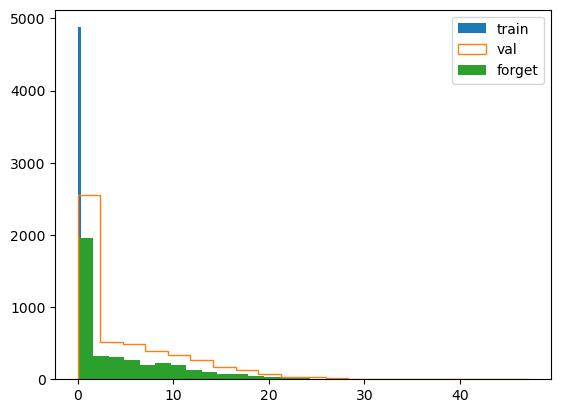

In [13]:
plt.hist(losses_train_mia, bins=20, label='train')
plt.hist(losses_val_mia, bins=20, histtype='step', label='val')
plt.hist(losses_forget_mia, bins=20, label='forget')
plt.legend()

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
X_train = np.concatenate((losses_train_mia, losses_val_mia)).reshape(-1, 1)
y_train = np.concatenate((np.ones(len(losses_train_mia)), np.zeros(len(losses_val_mia))))

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [21]:
y_losses_train = classifier.predict(np.array(losses_train_mia).reshape(-1, 1))

In [32]:
train_loss_error = len(y_losses_train) - sum(y_losses_train)

In [23]:
y_losses_val = classifier.predict(np.array(losses_val_mia).reshape(-1, 1))

In [33]:
val_error = sum(y_losses_val)

In [25]:
y_losses_forget = classifier.predict(np.array(losses_forget_mia).reshape(-1, 1))

In [29]:
sum(y_losses_forget)

1607.0

In [30]:
len(y_losses_forget)

4000

In [8]:
for key in ['original_model', 'euk', 'retrain']:
    weight_path=log_dir_dict_finetuned[key]+'_model.pth'
    all_values_retain_top5[key] = return_acc(weight_path, retain_loader, k=5)

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_sam_True_rho_0.5_lr_0.1_07-03-09:33:15_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-18:25:20_eu_9_at_shot_epoch_0_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_07-23-09:24:12_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812


In [9]:
all_values_retain_top5

{'SCRUB': 70.3857421875,
 'neggradplus': 73.291015625,
 'our_method': 97.6806640625,
 'original_model': 99.66754913330078,
 'euk': 4.515735626220703,
 'retrain': 99.98614501953125}

In [10]:
all_values_forget_top5 = dict()
for (key, log_dir) in log_dir_dict_finetuned.items():
    if key in ['original_model', 'euk', 'retrain']:
        continue

    log_dir = log_dir + '/Accuracy_train_top5_forget'
    print(log_dir)
    # Initialize the event accumulator
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Print all available tags (e.g., scalars, histograms, images, etc.)
    print(event_acc.Tags())

    # Get scalar data for a specific tag
    scalar_tag = 'Accuracy/train_top5'
    scalar_events = event_acc.Scalars(scalar_tag)

    all_values_forget_top5[key] = scalar_events[-1].value

/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-14:34:39_SCRUB/Accuracy_train_top5_forget
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Accuracy/train_top5'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-24-14:40:55_neggradplus/Accuracy_train_top5_forget
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Accuracy/train_top5'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.025_untrain07-24-15:52:07_constrained_lagrange/Accuracy_train_top5_forget
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Accuracy/train_top5'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


In [11]:
all_values_forget_top5

{'SCRUB': 36.7919921875, 'neggradplus': 37.3046875, 'our_method': 68.896484375}

In [12]:
for key in ['original_model', 'euk', 'retrain']:
    weight_path=log_dir_dict_finetuned[key]+'_model.pth'
    all_values_forget_top5[key] = return_acc(weight_path, forget_loader, k=5)

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_sam_True_rho_0.5_lr_0.1_07-03-09:33:15_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-18:25:20_eu_9_at_shot_epoch_0_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_07-23-09:24:12_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812


In [13]:
all_values_forget_top5

{'SCRUB': 36.7919921875,
 'neggradplus': 37.3046875,
 'our_method': 68.896484375,
 'original_model': 99.6826171875,
 'euk': 4.150390625,
 'retrain': 72.75390625}

In [14]:
all_values_validation_top5 = dict()
for (key, log_dir) in log_dir_dict_finetuned.items():
    if key in ['original_model', 'euk', 'retrain']:
        continue
    
    # log_dir = log_dir + '/Accuracy_train_top5_val'
    print(log_dir)
    # Initialize the event accumulator
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Print all available tags (e.g., scalars, histograms, images, etc.)
    print(event_acc.Tags())

    # Get scalar data for a specific tag
    scalar_tag = 'Accuracy/val_top5'
    scalar_events = event_acc.Scalars(scalar_tag)

    all_values_validation_top5[key] = scalar_events[-1].value

/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-14:34:39_SCRUB
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss/val', 'Accuracy/val_top1', 'Accuracy/val_top5'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': False, 'run_metadata': ['step1']}
/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-24-14:40:55_neggradplus
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss/val', 'Accuracy/val_top1', 'Accuracy/val_top5'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': False, 'run_metadata': ['step1']}
/home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.025_untrain07-24-15:52:07_constrained_lagrange
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['Loss/val', 'Accuracy/val_top1', 'Accuracy/val_top5', 'grad/train'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': False, 'run_metadata': ['step1']}


In [17]:
all_values_validation_top5

{'SCRUB': 47.517799377441406,
 'neggradplus': 48.279273986816406,
 'our_method': 64.84375,
 'original_model': 75.03955841064453,
 'euk': 4.460047721862793,
 'retrain': 70.84651947021484}

In [18]:
for key in ['original_model', 'euk', 'retrain']:
    weight_path=log_dir_dict_finetuned[key]+'_model.pth'
    all_values_validation_top5[key] = return_acc(weight_path, val_loader, k=5)

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_sam_True_rho_0.5_lr_0.1_07-03-09:33:15_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-18:25:20_eu_9_at_shot_epoch_0_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_07-23-09:24:12_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812


In [19]:
all_values_validation_top5

{'SCRUB': 47.517799377441406,
 'neggradplus': 48.279273986816406,
 'our_method': 64.84375,
 'original_model': 75.7911376953125,
 'euk': 4.49960470199585,
 'retrain': 71.11353302001953}

### MIA

In [8]:
num_samples_mia = 5000

train_indices = retain_loader.sampler.indices[:num_samples_mia]
val_indices = val_loader.sampler.indices[:num_samples_mia]

assert len(train_indices) == len(val_indices)
assert len(train_indices) == num_samples_mia

sampler_train_mia = torch.utils.data.SubsetRandomSampler(train_indices)
sampler_val_mia = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader_mia = torch.utils.data.DataLoader(retain_loader.dataset,
                                               batch_size=128,
                                               sampler=sampler_train_mia)
val_loader_mia = torch.utils.data.DataLoader(val_loader.dataset,
                                             batch_size=128,
                                             sampler=sampler_val_mia)

In [21]:
all_values_mia = dict()
for (key, log_dir) in log_dir_dict_finetuned.items():
    weight_path = log_dir + '_model.pth'
    model = get_model('resnet18', num_classes=100, pretrained_weights=None, weight_path=weight_path)
    model.eval()
    device = torch.device('cuda')
    model.to(device)
    all_values_mia[key] = mia_efficacy(model, train_loader_mia, val_loader_mia, forget_loader=forget_loader, device=device, loss_fn=torch.nn.CrossEntropyLoss(reduction='none'))

Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-14:34:39_SCRUB_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.2_untrain07-24-14:40:55_neggradplus_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.1_untrain07-24-18:25:20_eu_9_at_shot_epoch_0_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Trainable parameters: 11227812
Loaded weights from /home/gasanoe/HOME_SCRATCH_FOLDER/unlearning/logs/model_resnet18_lr_0.025_untrain07-24-15:52:07_constrained_lagrange_model.pth
Model 'resnet18' loaded successfully!
Number of layers: 62
Total parameters: 11227812
Train

In [22]:
for key, value in all_values_mia.items():
    all_values_mia[key] = value * 100

In [23]:
all_values_mia

{'SCRUB': 60.35,
 'neggradplus': 62.3,
 'euk': 48.449999999999996,
 'our_method': 49.775000000000006,
 'original_model': 3.0,
 'retrain': 59.575}

# Radar charts

In [24]:
# Sample data
labels = ['Test \n accuracy', 'Retain accuracy', 'Forget \n accuracy', 'MIA']
categories = log_dir_dict_finetuned.keys()
my_data = dict()
for key in categories:
    my_data[key] = [all_values_validation_top5[key], 
                    all_values_retain_top5[key],
                    all_values_forget_top5[key],
                    all_values_mia[key]]
# data = {
#     'Finetuning': [80, 85, 40, 90],
#     'Fisher': [70, 80, 35, 85],
#     'NegGrad+': [85, 90, 50, 95],
#     'CF-k': [60, 65, 30, 75],
#     'EU-k': [75, 80, 45, 85],
#     'Bad-T': [50, 55, 20, 60],
#     'SCRUB': [90, 95, 55, 100]
# }

In [25]:
# Number of variables
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

In [26]:
angles += angles[:1]

In [27]:
angles

[0.0, 1.5707963267948966, 3.141592653589793, 4.71238898038469, 0.0]

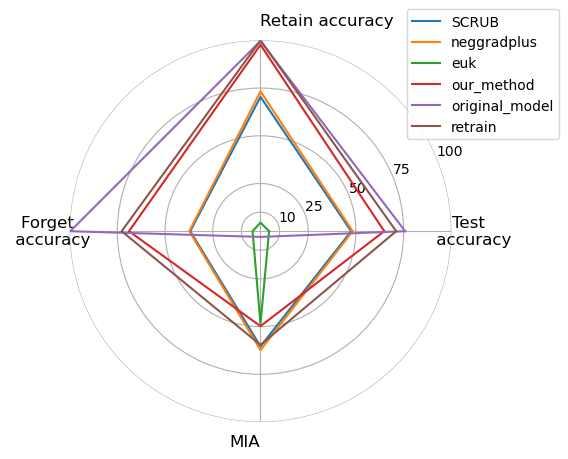

In [28]:
# Initialize the radar plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each category
for category in categories:
    values = copy.deepcopy(my_data[category])
    values += values[:1]
    ax.plot(angles, values, label=category)

# Add labels
ax.set_yticks([10, 25, 50, 75, 100])
ax.set_yticklabels([10, 25, 50, 75, 100])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Center the labels on the circumference
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

ax.set_ylim(0, 100)

# Remove the circumference line
ax.spines['polar'].set_visible(False)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.savefig('plots/radar_chart_unlearning.pdf')